<a href="https://colab.research.google.com/github/mrdbourke/airbnb-object-detection/blob/wip/06-detectron2-experiment-tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Preprocessing Code Improvements 

This notebook builds upon the Detectron2 experiment tracking notebook.

It is dedicated to improving data preprocessing code speed/robustness.

Previous notebook: https://colab.research.google.com/drive/1cdiavsEgnHHiKk9uz5LmkiVYuRfLgFt1

Original Detectron2 tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

+

<img src="https://i.imgur.com/1oTyk79.png" width="500">


# Install detectron2

In [ ]:
# # install dependencies: (use cu100 because colab is on CUDA 10.0)
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# # install detectron2:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# # WandB - Install the W&B library
# !pip install wandb -q

# # Need awscli to download images from AWS (labels come from GCP)
# !pip install awscli

# print("#### Versions: ####")
# import torch, torchvision
# torch.__version__
# !gcc --version
# # opencv is pre-installed on colab

In [ ]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

from detectron2.utils.visualizer import Visualizer

# Setup logger
logger = logging.getLogger("detectron2")

In [ ]:
# import some common libraries
import cv2
import json
import random
import os
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# wandb - Import weight's & biases
import wandb

import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

1.4.0+cu100
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# What GPU are we using?
!nvidia-smi

Fri Mar 20 07:27:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    37W / 250W |   8205MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# wandb - Login to wandb account so all metrics can be logged
!wandb login

In [ ]:
# Initialize Weights & Biases
import wandb
wandb.init(project="airbnb-object-detection", 
           sync_tensorboard=True)

W&B Run: https://app.wandb.ai/mrdbourke/airbnb-object-detection/runs/mu3dii69

# Setup Custom Dataset

TODO - add annotations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
valid_path = "/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-validation"
train_path = "/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-train"

**Note:** You only need to run the cell below once.

In [ ]:
# # Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html

# # Training bounding boxes (1.11G)
# !wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# # Validating bounding boxes (23.94M)
# !wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# # Testing bounding boxes (73.89M)
# !wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# # Class Names (11.73K)
# !wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2020-03-22 04:46:52--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G   104MB/s    in 14s     

2020-03-22 04:47:06 (82.1 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2020-03-22 04:47:09--  https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 2a00:1450:4013:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25105048 (24M) [text/csv]
Saving to: ‘val

In [ ]:
import pandas as pd
train_df = pd.read_csv("train-annotations-bbox.csv")
len(train_df)

14610229

In [ ]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

# # Create download string
# dl_string = ""
# for cat in subset:
#   cat = cat.replace("_", " ")
#   dl_string += cat+","
# dl_string[:-1]

What is `grep`?

`grep` is a command line utility for searching plain text documents for lines which match a certain regular expression: https://en.wikipedia.org/wiki/Grep

E.g.

"`grep /m/07xyvk ./train-annotations-bbox.csv`" will look for "`/m/07xyvk`" in "`./train-annotations-bbox.csv`"

In [ ]:
target_classes=["Coffeemaker", "Bathtub", "Tree house"]
target_classes.sort()
valid_img_path = "./validation"
train_img_path = "./train"

# Create download string based on target_classes
download_string = ""
for string in target_classes:
  download_string += string+","
download_string[:-1]

'Bathtub,Coffeemaker,Tree house'

In [ ]:
# !python3 downloadOI.py --dataset "train" --classes "Coffeemaker,Bathtub"

In [ ]:
# !python3 downloadOI.py --dataset "validation" --classes "Coffeemaker,Bathtub"

In [ ]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder) if img_name.endswith(".jpg")]

In [ ]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    # TODO - improve this, is pandas required? 
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])

    # Sort annot_file by "ClassName" for alphabetical labels (used with target_classes)
    annot_file.sort_values(by=["ClassName"], inplace=True)
    
    # TODO - fix this, Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassName"] = pd.Categorical(annot_file["ClassName"])
    annot_file["ClassID"] = annot_file["ClassName"].cat.codes
    
    return annot_file

In [ ]:
# %%time
# valid_annots = format_annotations(valid_path, 
#                                   annotation_file="/content/validation-annotations-bbox.csv",
#                                   target_classes=target_classes)
# valid_annots.head()

In [ ]:
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.round(np.multiply(bbox[0], width)) # x0
    bbox[1] = np.round(np.multiply(bbox[1], height)) # y0
    bbox[2] = np.round(np.multiply(bbox[2], width)) # x1
    bbox[3] = np.round(np.multiply(bbox[3], height)) # y1
    return [i.astype("object") for i in bbox] # convert all to objects for JSON saving

In [ ]:
import numpy as np
from detectron2.structures import BoxMode
import json
import os

def get_image_dicts(image_folder, annotation_file, target_classes=None):
    """
    Create JSON of dectectron2 style labels to be reused later.
    
    TODO -- Maybe create some verbosity here? In other words, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    dataset_name = "validation" if "valid" in image_folder else "train"

    print(f"Using {annotation_file} for annotations...")
    # TODO: there should be some kind of asssertions here making sure the image folder and annotation files match
    # E.g. train w/ train and valid w/ valid
    annotations = format_annotations(image_folder=image_folder, 
                                     annotation_file=annotation_file,
                                     target_classes=target_classes)

    print(f"On dataset: {dataset_name}")
    print("Classes we're using:\n {}".format(annotations["ClassName"].value_counts()))

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    print(f"Total number of images: {len(img_ids)}")

    # TODO: move img_data creation out of for loop and only work with subset of img_ids?
    #img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images with multiple objects
    #change to something like "img_data = annotations is in img_ids..."
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in tqdm(enumerate(img_ids)):
        record = {}
        
        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Verbosity for image label troubleshooting
        # print(f"On image: {img}")
        # print(f"Image category: {img_data.ClassID.values}")
        # print(f"Image label: {img_data.ClassName.values}")

        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # print(f"Image category 2: {category_id}")
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int # TODO: change for JSON
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)

    # TODO: Change this into it's own function??
    # Save img_dicts to JSON for use later
    json_file = os.path.join(image_folder, dataset_name+"_labels.json")
    print(f"Saving labels to: {json_file}...")
    with open(json_file, "w") as f:
      json.dump(img_dicts, f)

    # return img labels dictionary
    return img_dicts

In [ ]:
def load_json_labels(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on JSON label file in image_folder.
    
    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    """
    # Get absolute path of JSON label file
    for file in os.listdir(image_folder):
      if file.endswith(".json"):
        json_file = os.path.join(image_folder, file)

    # TODO: Fix this assertion
    assert json_file, "No .json label file found, please make one with annots_to_json()"

    with open(json_file, "r") as f:
      img_dicts = json.load(f)

    # Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
    for img_dict in img_dicts:
      for annot in img_dict["annotations"]:
        annot["bbox_mode"] = BoxMode.XYXY_ABS

    return img_dicts

## Make Labels

Use `annots_to_json()` to make image dictionaries in Detectron2 style and save them to JSON files for ease of use later.

In [ ]:
# %%time
# valid_img_dicts = annots_to_json(valid_path, 
#                                  "/content/validation-annotations-bbox.csv",
#                                  target_classes=target_classes)

In [ ]:
# %%time
# train_img_dicts = annots_to_json(train_path,
#                                  "/content/train-annotations-bbox.csv",
#                                  target_classes=target_classes)

## Import premade labels

In [ ]:
%%time
# These require .JSON files to be made in train/validation images folders
val_img_dicts = load_json_labels(valid_path)
train_img_dicts = load_json_labels(train_path)

CPU times: user 4.6 ms, sys: 2.17 ms, total: 6.77 ms
Wall time: 12.8 s


In [ ]:
val_img_dicts[0], train_img_dicts[1]

({'annotations': [{'bbox': [100.0, 157.0, 911.0, 683.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2}],
  'file_name': '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-validation/a571f1124483b074.jpg',
  'height': 683,
  'image_id': 0,
  'width': 1024},
 {'annotations': [{'bbox': [232.0, 554.0, 680.0, 1000.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-train/e32f08801c4d30d0.jpg',
  'height': 1024,
  'image_id': 1,
  'width': 768})

# Train on a custom dataset

## plain_train_net.py 

I'm going to write out the plain_train_net.py script verbatim to see what it's doing.

https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

I'll leave notes and change it where I need to.

In [ ]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models_to_try = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

## Register dataset
Before I can train a model I've got to register a dataset in Detectron2 style: https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset

This will leverage my preprocessing functions.

**Note:** Be sure to update the config for new datasets: https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets

In [ ]:
# Setup training and validation data paths
train_path, valid_path, target_classes

('/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-train',
 '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-validation',
 ['Bathtub', 'Coffeemaker', 'Tree house'])

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

def register_datasets(train_path, valid_path=None, target_classes=None):
  """
  Registers a Detectron2 style dataset from training paths.

  Params
  ------
  train_path (str) : pathname to training data containing training images
  valid_path (str) : pathname to validation data containing validation images
  """
  # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
  # E.g. {"training": "path/to/training",
  #          "valid": "path/to/valid"}
  for d in [train_path, valid_path]:
    dataset_name = d.split("/")[-1]
    print("Registering: {}".format(dataset_name))
    DatasetCatalog.register(dataset_name, lambda d=d: load_json_labels(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)
  return MetadataCatalog.get(dataset_name)

In [ ]:
cmaker_bathtub_metadata = register_datasets(train_path=train_path,
                                            valid_path=valid_path,
                                            target_classes=target_classes)

Registering: cmaker-bathtub-treehouse-train
Registering: cmaker-bathtub-treehouse-validation


In [ ]:
# # Check registered dataset
# DatasetCatalog._REGISTERED

In [ ]:
# # Remove a certain registered dataset if needed:
# DatasetCatalog._REGISTERED.pop()

## TODO - Visualize dataset

Once you've got a dataset registered with Detectron2 it's a good idea to be able to visualize an image.

In [ ]:
val_img_dicts[0]

{'annotations': [{'bbox': [100.0, 157.0, 911.0, 683.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2}],
 'file_name': '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-validation/a571f1124483b074.jpg',
 'height': 683,
 'image_id': 0,
 'width': 1024}

In [ ]:
def visualize_sample(data_dicts, metadata, n=1):
  """
  Show n random samples from data_dicts, label with metadata.
  """
  for d in random.sample(data_dicts, n):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

{'file_name': '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-train/04a16a805d8fedd4.jpg', 'image_id': 839, 'height': 765, 'width': 1024, 'annotations': [{'bbox': [0.0, 467.0, 901.0, 764.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


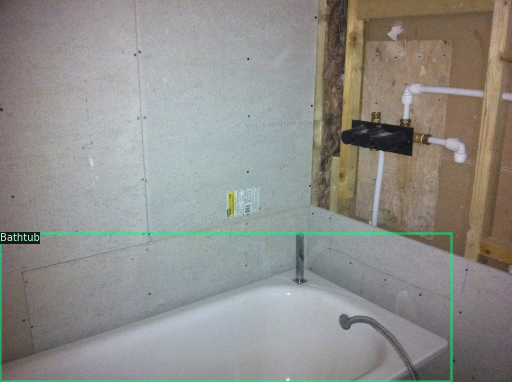

{'file_name': '/content/drive/My Drive/Airbnb/cmaker-bathtub-treehouse-train/7ad5584aa00e667f.jpg', 'image_id': 222, 'height': 1024, 'width': 768, 'annotations': [{'bbox': [459.0, 392.0, 592.0, 581.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1}]}


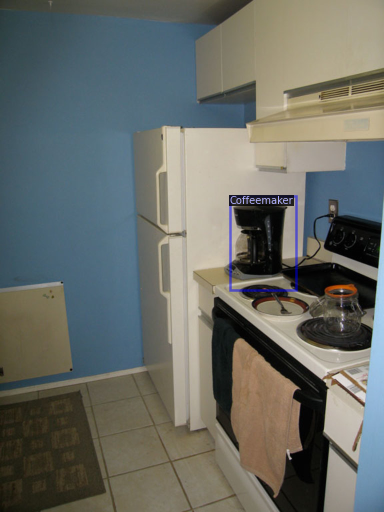

In [ ]:
visualize_sample(train_img_dicts, cmaker_bathtub_metadata, n=2)

## Train

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [ ]:
# # Example setup of default config
# default_config = get_cfg()
# default_config.DATASETS.TRAIN = ("my-training-data",)
# default_config.DATASETS

In [ ]:
# Example use case of model_zoo
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [ ]:
# Changed from original: Create evaluator for COCOEvaluator only 
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
  """
  Create a COCOEvaluator
  """
  if output_folder is None:
    output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
  evaluator = COCOEvaluator(
      dataset_name=dataset_name,
      cfg=cfg,
      distributed=False,
      output_dir=output_folder
  )
  return evaluator

In [ ]:
# Create testing function
def do_test(cfg, model):
  results = OrderedDict()
  for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    # Create the evaluator
    evaluator = get_evaluator(
        cfg, 
        dataset_name,
        output_folder=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    # Make inference on dataset
    results_i = inference_on_dataset(model,
                                     data_loader,
                                     evaluator)
    # Update results dictionary
    results[dataset_name] = results_i

    print("### Returning results_i...")
    #print(results_i)
    #print(f"### Average Precision: {results_i['AP']}")
    # Let's get some communication happening
    if comm.is_main_process():
      logger.info("Evaluation results for {} in csv format:".format(dataset_name))
      ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
      #print("### Calculating results...")
      print_csv_format(results_i)
    
    # Check to see length of results
    if len(results) == 1:
      results = list(results.values())[0]
    #print("### Returning results...")
    #print(results)

    # TODO : log results_i dict with different parameters
    print("### Saving results to Weights & Biases...")
    wandb.log(results_i)

    return results


Source code for Checkpointer: https://detectron2.readthedocs.io/_modules/fvcore/common/checkpoint.html

Maybe information from the Checkpointers can be saved to Weights & Biases? Or at least used to track in my own tracking.

In [ ]:
# Create training function
def do_train(cfg, model, resume=False):
  # Set model to training mode
  model.train()
  # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
  optimizer = build_optimizer(cfg, model)
  # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
  scheduler = build_lr_scheduler(cfg, optimizer)
  print(f"Scheduler: {scheduler}")

  # Create checkpointer
  checkpointer = DetectionCheckpointer(
      model, save_dir=cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
  )

  # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
  start_iter = (
      # This can be 0
      checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, # Use predefined model weights (pretrained model)
                                  resume=resume).get("iteration", -1) + 1
  )
  # Set max number of iterations
  max_iter = cfg.SOLVER.MAX_ITER

  # Create periodiccheckpoint
  periodic_checkpointer = PeriodicCheckpointer(checkpointer=checkpointer,
                                               # How often to make checkpoints?
                                               period=cfg.SOLVER.CHECKPOINT_PERIOD,
                                               max_iter=max_iter)
  
  # Create writers (for saving checkpoints?)
  writers = (
      [
       # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
       CommonMetricPrinter(max_iter=max_iter),
       # Write scalars to a JSON file such as loss values, time and more
       JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
       # Write all scalars such as loss values to a TensorBoard file for easy visualization
       TensorboardXWriter(cfg.OUTPUT_DIR),
      ]
      if comm.is_main_process()
      else []
  )

  ### Original note from script: ###
  # compared to "train_net.py", we do not support accurate timing and precise BN
  # here, because they are not trivial to implement

  # Build a training data loader based off the training dataset name in the config
  data_loader = build_detection_train_loader(cfg)

  # Start logging
  logger.info("Starting training from iteration {}".format(start_iter))

  # Store events
  with EventStorage(start_iter) as storage:
    # Loop through zipped data loader and iteration
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
      iteration = iteration + 1
      storage.step() # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

      # Create loss dictionary by trying to model data
      loss_dict = model(data)
      losses = sum(loss_dict.values())
      # Are losses infinite? If so, something is wrong
      assert torch.isfinite(losses).all(), loss_dict

      # TODO - Not quite sure what's happening here
      loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
      # Sum up losses
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())
      
      # # TODO: wandb.log()? log the losses
      # wandb.log({
      #     "Total loss": losses_reduced
      # })

      # Update storage
      if comm.is_main_process():
        # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
        storage.put_scalars(total_loss=losses_reduced,
                            **loss_dict_reduced)
      
      # Start doing PyTorch things
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      # Add learning rate to storage information
      storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
      # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
      scheduler.step()

      # Perform evaluation?
      if (
          cfg.TEST.EVAL_PERIOD > 0
          and iteration % cfg.TEST.EVAL_PERIOD == 0
          and iteration != max_iter
      ):
          do_test(cfg, model)
          # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
          comm.synchronize()
      
      # Log different metrics with writers
      if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
        for writer in writers:
          writer.write()
      
      # Update the periodic_checkpointer
      periodic_checkpointer.step(iteration)

`default_setup()` - https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.default_setup

In [ ]:
# Create setup function
def setup(args):
  """
  Create configs and perform basic setups.
  """
  cfg = get_cfg()
  cfg.merge_from_file(args.config_file) # This will take some kind of model.yaml file
  cfg.merge_from_list(args.opts)
  cfg.freeze()
  default_setup(
      cfg, args
  ) # this logs the config and arguments passed to the command line to the output file

  # Load config YAML as dict
  cfg_yaml = cfg.load_yaml_with_base(os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

  # default_config = get_cfg()
  # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
  # default_config_loaded

  # TODO: turn config into YAML and save to weights & biases
  # TODO: Init wandb and add configs
  # Setup a new weights & biases run every time we run the setup() function
  wandb.init(project="airbnb-object-detection", 
             sync_tensorboard=True)
  
  #print("### Printing config_yaml file to go into Weights & Biases")
  #print(cfg_yaml)
  wandb.config.update(cfg_yaml)

  return cfg

In [ ]:
# Create main function
def main(args):
  
  # Create the config file
  cfg = setup(args)

  # Build the model
  model = build_model(cfg)
  
  # Log what's going on
  logger.info("Model:\n{}".format(model))

  # TODO: Fix this (if it doesn't work)
  #wandb.watch(model, log="all")

  # Only do evaluation if the args say so
  if args.eval_only:
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    return do_test(cfg, model)

  # Do distributed training? (depends on number of GPUs available)
  distributed = comm.get_world_size() > 1
  if distributed:
    # Put the model on multiple devices if available
    model = DistributedDataParallel(
        model, 
        device_ids=[comm.get_local_rank()], 
        broadcast_buffers=False
    )

  # Train the model
  do_train(cfg, model)
  # TODO - May want to evaluate in a different step?
  return do_test(cfg, model)

## TODO: Setup different experiments for `models_to_try`

In [ ]:
models_to_try

{'R101-FPN-3x': 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'R50-FPN-1x': 'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'R50-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'RN-R101-3x': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml',
 'RN-R50-1x': 'COCO-Detection/retinanet_R_50_FPN_1x.yaml',
 'RN-R50-3x': 'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
 'X101-FPN-3x': 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'}

In [ ]:
models_to_try["R50-FPN-1x"]

'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'

In [ ]:
model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml')

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [ ]:
model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'

Let's use a MAX_ITER of ~30 whilst we're building a small model.

We'll also change some defaults:
* `SOLVER.IMS_PER_BATCH` = 16 -> 2 (lower for memory issues)
* `DATALOADER.NUM_WORKERS` = 4 -> 2 (lower for memory issues)

These lowering settings are based on the example Detectron2 tutorial notebook (which runs in Colab), we can update them later once we figure out what resources we're using.

See this post for an example of resource use: https://lambdalabs.com/blog/weights-and-bias-gpu-cpu-utilization/

Note: Set `SEED` in config for reproducibility.

In [ ]:
# Setup arg parser
parser = default_argument_parser() # default in Detectron2

In [ ]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models_to_try.items():
  model = models_to_try[k]
  model_weights = model_zoo.get_checkpoint_url(model)
  weights.append(model_weights)
  config_file = model_zoo.get_config_file(model)
  configs.append(config_file)
weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl': '/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl': '/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl': '/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl': '/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Det

In [ ]:
# Setup different arg strings to pass to main() 
workers = 2
ims_per_batch = 2
lr = 0.00025
max_iter = 3000
seed = 33
num_classes = len(target_classes)

arg_strings = []
for weights, config in weights_configs.items():
  arg_string = f"--config-file {config} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('cmaker-bathtub-treehouse-train',) \
                DATASETS.TEST ('cmaker-bathtub-treehouse-validation',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SEED {seed} \
                MODEL.ROI_HEADS.NUM_CLASSES {num_classes}".split()
  arg_strings.append(arg_string)

In [ ]:
# Create different arg parsers
arg_list = []
for arg_string in arg_strings:
  args = parser.parse_args(arg_string)
  print(args)
  arg_list.append(args)

Namespace(config_file='/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)
Namespace(config_file='/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50

In [ ]:
arg_list[0]

Namespace(config_file='/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)

## Run custom training loop

In [ ]:
for i, namespace in enumerate(arg_list):
  print(f"Running experiment: {1}") # derp......
  main(namespace)

Runing experiment: 1
[03/20 05:04:20 detectron2]: Rank of current process: 0. World size: 1
[03/20 05:04:20 detectron2]: Environment info:
------------------------  ---------------------------------------------------------------
sys.platform              linux
Python                    3.6.9 (default, Nov  7 2019, 10:44:02) [GCC 8.3.0]
numpy                     1.18.2
detectron2                0.1.1 @/usr/local/lib/python3.6/dist-packages/detectron2
detectron2 compiler       GCC 7.3
detectron2 CUDA compiler  10.0
detectron2 arch flags     sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0+cu100 @/usr/local/lib/python3.6/dist-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla P100-PCIE-16GB
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.0, V10.0.130
Pillow                    7.0.0
torchvision           

[03/20 05:04:21 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[03/20 05:18:53 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[03/20 05:33:28 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

model_final_f6e8b1.pkl: 243MB [00:20, 11.7MB/s]                           

[03/20 05:33:49 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl. 243480188 bytes.
[03/20 05:33:49 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl


[03/20 05:33:49 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [03/20 05:33:49 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
WARNING [03/20 05:33:49 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
WARNING [03/20 05:33:49 fvcore.common.checkpoint]: 'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
WARNING [03/20 05:33:49 fvcore.common.checkpoint]: 'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
[03/20 05:33:49 fvcore.common.checkpoint]: Some model parameters are not in the checkpoint:
  roi_heads.box_predictor.cls_score.{weight, bias}
  roi_heads.box_predictor.bbox_pred.{weight, bias}
[03/20 05:33:49 d2.data.build]: Removed 0 images with no usa

[03/20 05:53:59 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

model_final_68b088.pkl: 421MB [00:34, 12.1MB/s]                           

[03/20 05:54:34 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl. 420839087 bytes.
[03/20 05:54:34 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl


[03/20 05:54:34 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [03/20 05:54:34 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
WARNING [03/20 05:54:34 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
WARNING [03/20 05:54:34 fvcore.common.checkpoint]: 'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
WARNING [03/20 05:54:34 fvcore.common.checkpoint]: 'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
[03/20 05:54:34 fvcore.common.checkpoint]: Some model parameters are not in the checkpoint:
  roi_heads.box_predictor.cls_score.{weight, bias}
  roi_heads.box_predictor.bbox_pred.{weight, bias}
[03/20 05:54:34 d2.data.build]: Removed 0 images with no usa

[03/20 06:37:57 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

model_final_b796dc.pkl: 152MB [00:13, 10.9MB/s]                           

[03/20 06:38:11 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/137593951/model_final_b796dc.pkl. 152130042 bytes.
[03/20 06:38:11 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/137593951/model_final_b796dc.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/137593951/model_final_b796dc.pkl


[03/20 06:38:11 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[03/20 06:38:11 d2.data.build]: Removed 0 images with no usable annotations. 873 images left.
[03/20 06:38:11 d2.data.common]: Serializing 873 elements to byte tensors and concatenating them all ...
[03/20 06:38:11 d2.data.common]: Serialized dataset takes 0.25 MiB
[03/20 06:38:11 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/20 06:38:11 d2.data.build]: Using training sampler TrainingSampler
[03/20 06:38:11 detectron2]: Starting training from iteration 0
[03/20 06:38:18 d2.utils.events]:  eta: N/A  iter: 20  total_loss: 1.398  loss_cls: 1.308  loss_box_reg: 0.164      lr: 0.000005  max_mem: 6727M
[03/20 06:38:23 d2.utils.events]:  eta: N/A  iter: 40  total_loss: 1.481  loss_cls: 1.268  loss_box_reg: 0.106      lr: 0.000010  max_mem: 6727M
[03/20 06:38:29 d2.utils.e

[03/20 06:52:07 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

model_final_4cafe0.pkl: 152MB [00:13, 11.0MB/s]                           

[03/20 06:52:20 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl. 152130042 bytes.
[03/20 06:52:20 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl


[03/20 06:52:21 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[03/20 06:52:21 d2.data.build]: Removed 0 images with no usable annotations. 873 images left.
[03/20 06:52:21 d2.data.common]: Serializing 873 elements to byte tensors and concatenating them all ...
[03/20 06:52:21 d2.data.common]: Serialized dataset takes 0.25 MiB
[03/20 06:52:21 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/20 06:52:21 d2.data.build]: Using training sampler TrainingSampler
[03/20 06:52:21 detectron2]: Starting training from iteration 0
[03/20 06:52:26 d2.utils.events]:  eta: N/A  iter: 20  total_loss: 1.680  loss_cls: 1.595  loss_box_reg: 0.177      lr: 0.000005  max_mem: 6727M
[03/20 06:52:32 d2.utils.events]:  eta: N/A  iter: 40  total_loss: 1.662  loss_cls: 1.464  loss_box_reg: 0.112      lr: 0.000010  max_mem: 6727M
[03/20 06:52:37 d2.utils.e

[03/20 07:06:14 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

model_final_59f53c.pkl: 228MB [00:20, 11.4MB/s]                           

[03/20 07:06:34 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl. 228343351 bytes.
[03/20 07:06:34 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl


[03/20 07:06:35 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[03/20 07:06:35 d2.data.build]: Removed 0 images with no usable annotations. 873 images left.
[03/20 07:06:35 d2.data.common]: Serializing 873 elements to byte tensors and concatenating them all ...
[03/20 07:06:35 d2.data.common]: Serialized dataset takes 0.25 MiB
[03/20 07:06:35 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/20 07:06:35 d2.data.build]: Using training sampler TrainingSampler
[03/20 07:06:35 detectron2]: Starting training from iteration 0
[03/20 07:06:42 d2.utils.events]:  eta: N/A  iter: 20  total_loss: 1.743  loss_cls: 1.642  loss_box_reg: 0.157      lr: 0.000005  max_mem: 6727M
[03/20 07:06:50 d2.utils.events]:  eta: N/A  iter: 40  total_loss: 1.911  loss_cls: 1.744  loss_box_reg: 0.136      lr: 0.000010  max_mem: 6727M
[03/20 07:06:58 d2.utils.e

In [ ]:
if __name__ == "__main__":
  main(args)

[03/20 04:30:56 detectron2]: Rank of current process: 0. World size: 1
[03/20 04:30:56 detectron2]: Environment info:
------------------------  ---------------------------------------------------------------
sys.platform              linux
Python                    3.6.9 (default, Nov  7 2019, 10:44:02) [GCC 8.3.0]
numpy                     1.18.2
detectron2                0.1.1 @/usr/local/lib/python3.6/dist-packages/detectron2
detectron2 compiler       GCC 7.3
detectron2 CUDA compiler  10.0
detectron2 arch flags     sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0+cu100 @/usr/local/lib/python3.6/dist-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla P100-PCIE-16GB
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.0, V10.0.130
Pillow                    7.0.0
torchvision               0.5.0+cu100 @/usr

[03/20 04:30:57 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

In [ ]:
results_dict = OrderedDict([('bbox', 
                             {'AP': 0.421105753554186, 
                              'AP50': 2.570381670807977, 
                              'AP75': 0.0034985830738550883, 
                              'APs': None, 
                              'APm': None, 
                              'APl': 0.5861111021958075})])
results_dict["bbox"]["AP"]

0.421105753554186

# SUCCESS!!!!!!!

Model trained with a custom training loop! Now to figure out how to track experiments....

In [ ]:
# if __name__ == "__main__":
#   # Creates an argument parser with common arguments used by Detectron2
#   args = default_argument_parser().parse_args()
#   print("Command Line Args:", args)
#   # Abstracted funciton for launching the main() function with a bunch of different things
#   launch(
#       main,
#       args.num_gpus,
#       num_machines=args.num_machines,
#       machine_rank=args.machine_rank,
#       dist_url=args.dist_url,
#       args=(args,),
#   )

usage: ipykernel_launcher.py [-h] [--config-file FILE] [--resume]
                             [--eval-only] [--num-gpus NUM_GPUS]
                             [--num-machines NUM_MACHINES]
                             [--machine-rank MACHINE_RANK]
                             [--dist-url DIST_URL]
                             ...
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## TODO - Draw predictions

In [ ]:
import detectron2
# Load in config file
loaded_cfg = get_cfg()
loaded_cfg = loaded_cfg.load_yaml_with_base(os.path.join(loaded_cfg.OUTPUT_DIR, "config.yaml"))
loaded_cfg = detectron2.config.CfgNode(loaded_cfg)
# loaded_cfg

In [ ]:
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"]

0.05

In [ ]:
from detectron2.engine import DefaultPredictor
# Setup predictor
loaded_cfg["MODEL"]["WEIGHTS"] = os.path.join(loaded_cfg["OUTPUT_DIR"], "model_final.pth")
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"] = 0.7   # set the testing threshold for this model
loaded_cfg["DATASETS"]["TEST"] = ("cmaker-bathtub-treehouse-validation", )
predictor = DefaultPredictor(loaded_cfg)

[03/18 06:09:17 fvcore.common.checkpoint]: Loading checkpoint from ./output/model_final.pth


{'instances': Instances(num_instances=2, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 332.9039,  238.9931, 1021.1638,  768.0000],
        [  75.1831,  523.6356,  566.5775,  768.0000]], device='cuda:0')), scores: tensor([0.8273, 0.7050], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


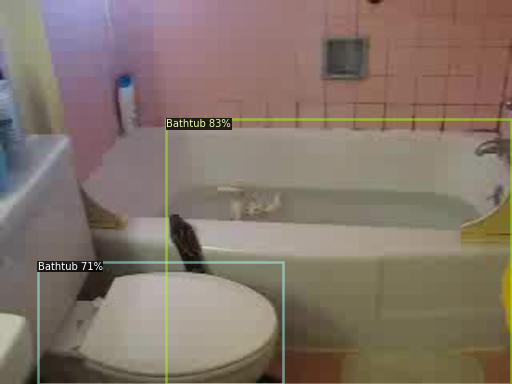

In [ ]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cmaker_bathtub_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])